In [1]:
%load_ext autoreload
%autoreload 2
CUDA_LAUNCH_BLOCKING=1

In [2]:
import detectron2
import torch
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
import matplotlib
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['figure.dpi']=100
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from vis_det.model_pool import get_data, get_model
from vis_det.data import query_image,data_preprocessing
from detectron2.utils.visualizer import Visualizer
from vis_det.optimize import layout_optimize, layout_vis_loss

In [4]:
## load data 
coco_val, coco_val_meta = get_data("kitti_detection")
# coco_val, coco_val_meta = get_data("kitti_semantics")

['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_minival_100', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2014_minival_100', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5_train_cocofied', 'lvis_v0.5_val_cocofied', 'cityscapes_fine_in

100%|██████████| 10/10 [00:00<00:00, 103.21it/s]


In [5]:
## load model and corresponding arg, cfg and predictor.
# model, args, cfg, predictor = get_model("Cityscapes/mask_rcnn_R_50_FPN")
# model, args, cfg, predictor = get_model("COCO-Detection/retinanet_R_50_FPN")
model, args, cfg, predictor = get_model("COCO-Detection/faster_rcnn_R_50_FPN")

In [6]:
coco_val[1]

{'file_name': '/home/devenish/Desktop/delight/datasets/kitti_object/training/image_2/000001.png',
 'image_id': 1,
 'height': 375,
 'width': 1242,
 'annotations': [{'bbox': (387, 181, 423, 203),
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 2,
   'iscrowd': 0}]}

In [7]:
## load the target image layouts and show.
#target_img = "000000439715"
target_img = coco_val[2]['file_name']
target_image = query_image(target_img, coco_val)
#print(target_image)

/home/devenish/Desktop/delight/datasets/kitti_object/training/image_2/000002.png


In [8]:
images, gt_instances, mapper_target = data_preprocessing(cfg,target_image,model)


Mask on is  False


In [9]:
gt_instances

[Instances(num_instances=1, image_height=402, image_width=1333, fields=[gt_boxes: Boxes(tensor([[705., 203., 751., 239.]])), gt_classes: tensor([2])])]

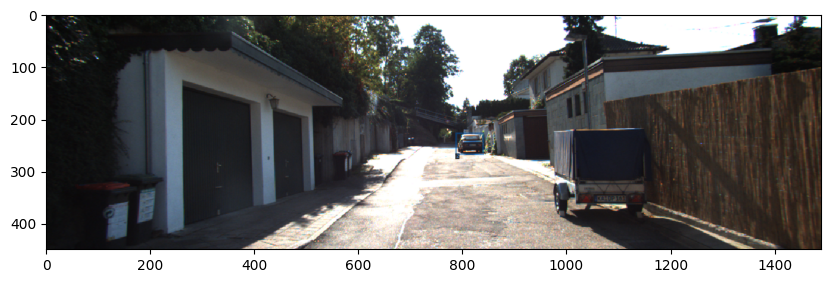

In [10]:
img = cv2.imread(target_image["file_name"])
visualizer = Visualizer(img, metadata=coco_val_meta, scale=1.2)
vis = visualizer.draw_dataset_dict(target_image)
plt.imshow(vis.get_image()[:,:,::-1])

In [11]:
%%time
loss_func = layout_vis_loss(args)
inverter = layout_optimize(args, cfg)
x = inverter.invert(images, gt_instances, model, loss_func)

Into Invert
Faster Invert
Initialization 
iteration 0
iteration 100


The GPU memory usage is around 4GB.
CPU times: user 11min 53s, sys: 13.8 s, total: 12min 7s
Wall time: 3min 1s

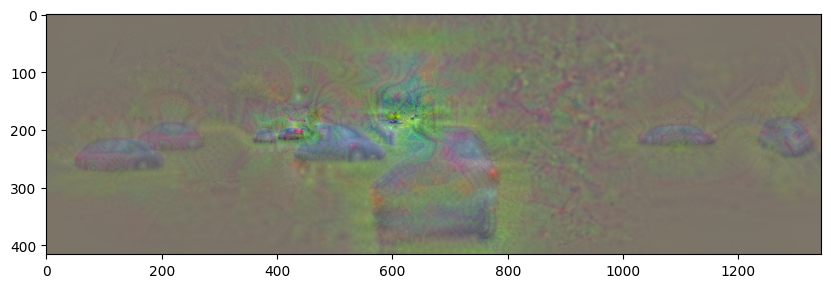

In [9]:
# draw the inverse
inverse_img = inverter.post_processing(x)
plt.imshow(inverse_img[0][:,:,::-1])

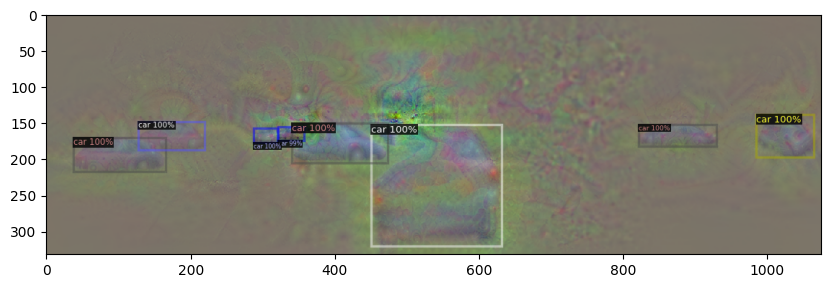

In [10]:
## show the prediction results.
inverse_img = inverse_img[0]
outputs = predictor(inverse_img)
v1 = Visualizer(inverse_img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
v1 = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v1.get_image())